# N8OBJ Doppler

In [1]:
import os
import datetime
import string
letters = string.ascii_lowercase

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from astropy.coordinates import EarthLocation

import harc_plot
from harc_plot import geopack
import eclipse_calc

%matplotlib inline

Re = 6371 # Radius of the Earth in km

In [2]:
mpl.rcParams['font.size']      = 12
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = np.array([15, 8])
mpl.rcParams['axes.xmargin']   = 0

## Station Data

In [3]:
stations    = []
g = {}
g['call_sign'] = 'WWV'
g['lat']       =  40.68
g['lon']       = -105.04
stations.append(g)

g = {}
g['call_sign'] = 'N8OBJ'
g['lat']       =  41.321963
g['lon']       = -81.504739
stations.append(g)

stations_df = pd.DataFrame(stations)
stations_df.set_index('call_sign',inplace=True)

tmp_lst = []
tx_call = 'WWV'
for call_sign,row in stations_df.iterrows():
    print(call_sign)
    if call_sign == tx_call:
        tmp_lst.append(row)
        continue
    
    lat_0 = stations_df.loc[tx_call]['lat']
    lon_0 = stations_df.loc[tx_call]['lon']
    lat_1 = row['lat']
    lon_1 = row['lon']
    
    rng      = Re*geopack.greatCircleDist(lat_0,lon_0,lat_1,lon_1)
    azm_from = geopack.greatCircleAzm(lat_0,lon_0,lat_1,lon_1)
    azm_to   = geopack.greatCircleAzm(lat_1,lon_1,lat_0,lon_0)
    
    res      = geopack.greatCircleMove(lat_0,lon_0,rng/2.,azm_from,Re=Re)
    
    row['mid_lat'] = res[0][0]
    row['mid_lon'] = res[1][0]
    
    row['azm_to_{!s}'.format(tx_call)]   = azm_to
    row['azm_from_{!s}'.format(tx_call)] = azm_from
    row['range_km'] = rng
    
    tmp_lst.append(row)
    
stations_df = pd.DataFrame(tmp_lst)

mid_lat = stations_df.loc['N8OBJ']['mid_lat']
mid_lon = stations_df.loc['N8OBJ']['mid_lon']

stations_df

WWV
N8OBJ


,lat,lon,mid_lat,mid_lon,azm_to_WWV,azm_from_WWV,range_km
WWV,40.680000,-105.040000,NaN,NaN,NaN,NaN,NaN
N8OBJ,41.321963,-81.504739,41.604411,-93.330499,-84.258004,80.176532,1970.277449


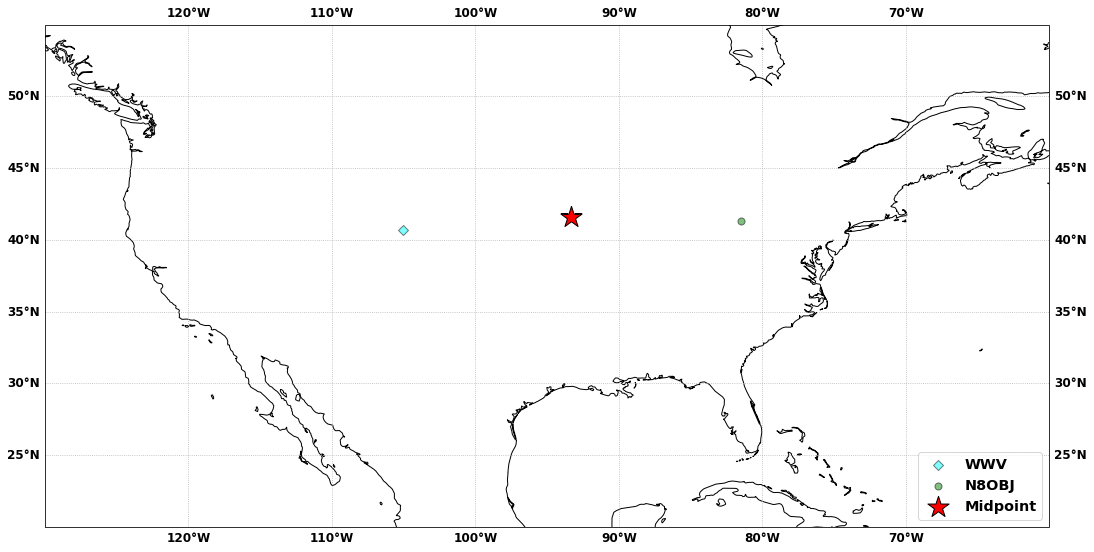

In [4]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,14))
ax  = fig.add_subplot(1,1,1,projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)

alpha = 0.5
# Plot Transmitter
call = 'WWV'
lat  = stations_df.loc[call]['lat']
lon  = stations_df.loc[call]['lon']
ax.scatter([lon],[lat],marker='D',s=50,color='Cyan',label=call,ec='black',alpha=alpha)

# Plot Receiver
call = 'N8OBJ'
lat  = stations_df.loc[call]['lat']
lon  = stations_df.loc[call]['lon']
ax.scatter([lon],[lat],marker='o',s=50,color='green',label=call,ec='black',alpha=alpha)

# Plot Midpoint
call = 'N8OBJ'
lat  = stations_df.loc[call]['mid_lat']
lon  = stations_df.loc[call]['mid_lon']
ax.scatter([lon],[lat],marker='*',s=500,color='red',label='Midpoint',ec='black')

ax.legend(loc='lower right',fontsize='large')
    
# # World Limits
# ax.set_xlim(-180,180)
# ax.set_ylim(-90,90)

# US Limits
ax.set_xlim(-130,-60)
ax.set_ylim(20,55)

plt.show()

## Load and PrepareData

In [5]:
# Load Data from CSV
fpath  = 'data/n8obj/N8OBJ Node 7 10 MHz 5 min cadence.csv.bz2'
df_raw = pd.read_csv(fpath,index_col=0)

In [6]:
## Initialize New DataFrame

# Create Date Vector
sTime = datetime.datetime(2020,7,28)
eTime = datetime.datetime(2022,4,20)
dt    = datetime.timedelta(minutes=5)

dates = [sTime]
while dates[-1] < eTime:
    dates.append(dates[-1]+dt)
    
# Generate Empty Data
dopp  = np.zeros(len(dates))*np.nan

# Initialize New Data Frame
df = pd.DataFrame({'doppler':dopp},index=dates)

In [7]:
df

,doppler
2020-07-28 00:00:00,NaN
2020-07-28 00:05:00,NaN
2020-07-28 00:10:00,NaN
2020-07-28 00:15:00,NaN
2020-07-28 00:20:00,NaN
...,...
2022-04-19 23:40:00,NaN
2022-04-19 23:45:00,NaN
2022-04-19 23:50:00,NaN
2022-04-19 23:55:00,NaN


In [8]:
# Put data into a flattened data frame and compute solar local time.

# Convert the raw index UT time strings into integers.
hms_ut = []
for ut_str in df_raw.index:
    hms_str = ut_str.split(':')
    hr = int(hms_str[0])
    mn = int(hms_str[1])
    sc = int(hms_str[2])
    
    hms_ut.append( (hr,mn,sc) )

for col_key in tqdm(df_raw.keys(),desc='Reordering Data',dynamic_ncols=True):
    date_str = col_key.split('.')[0]
    date     = datetime.datetime.strptime(date_str,'%d %b %Y')
    # print(date_str, date)
    for inx,val in enumerate(df_raw[col_key].values):
        # print(inx,hms_ut[inx],val)
        hms     = hms_ut[inx]
        hms_td  = datetime.timedelta(hours=hms[0],minutes=hms[1],seconds=hms[2])
        date_ut = date+hms_td
        
        lon              = stations_df.loc['N8OBJ']['mid_lon']
        midpoint_slt     = date_ut + datetime.timedelta(hours=(lon/15.))
        midpoint_slt_day = datetime.datetime(midpoint_slt.year,midpoint_slt.month,midpoint_slt.day)
        midpoint_slt_hr  = midpoint_slt.hour + midpoint_slt.minute/60. + midpoint_slt.second/3600.
        
        if not np.isnan(val):
            df.loc[date_ut,'doppler']          = val
            df.loc[date_ut,'midpoint_slt']     = midpoint_slt
            df.loc[date_ut,'midpoint_slt_hr']  = midpoint_slt_hr
            df.loc[date_ut,'midpoint_slt_day'] = midpoint_slt_day
            
df.dropna(inplace=True)

Reordering Data:   0%|                                                                                        …

In [9]:
# Create bins for Solar Local Time
dt_hr    = dt.total_seconds()/3600.
slt_bins = np.arange(0,24+dt_hr,dt_hr)

# Get SLT Days and Remove NaTs
slt_days = df['midpoint_slt_day'].unique()
tf       = ~np.isnan(slt_days)
slt_days = slt_days[tf]
slt_days.sort()

In [10]:
# Rearrange Doppler Data into a 2D Array
doppler_slt_arr = np.zeros( (len(slt_days), len(slt_bins)) )*np.nan
for rinx, row in tqdm(df.iterrows(),total=len(df),dynamic_ncols=True,desc='Filling doppler_slt_arr'):
    val         = row['doppler']
    slt_day_inx = np.where(row['midpoint_slt_day'] == slt_days)[0][0]
    slt_bin_inx = np.digitize(row['midpoint_slt_hr'],slt_bins)
        
    doppler_slt_arr[slt_day_inx,slt_bin_inx] = val

Filling doppler_slt_arr:   0%|                                                                                …

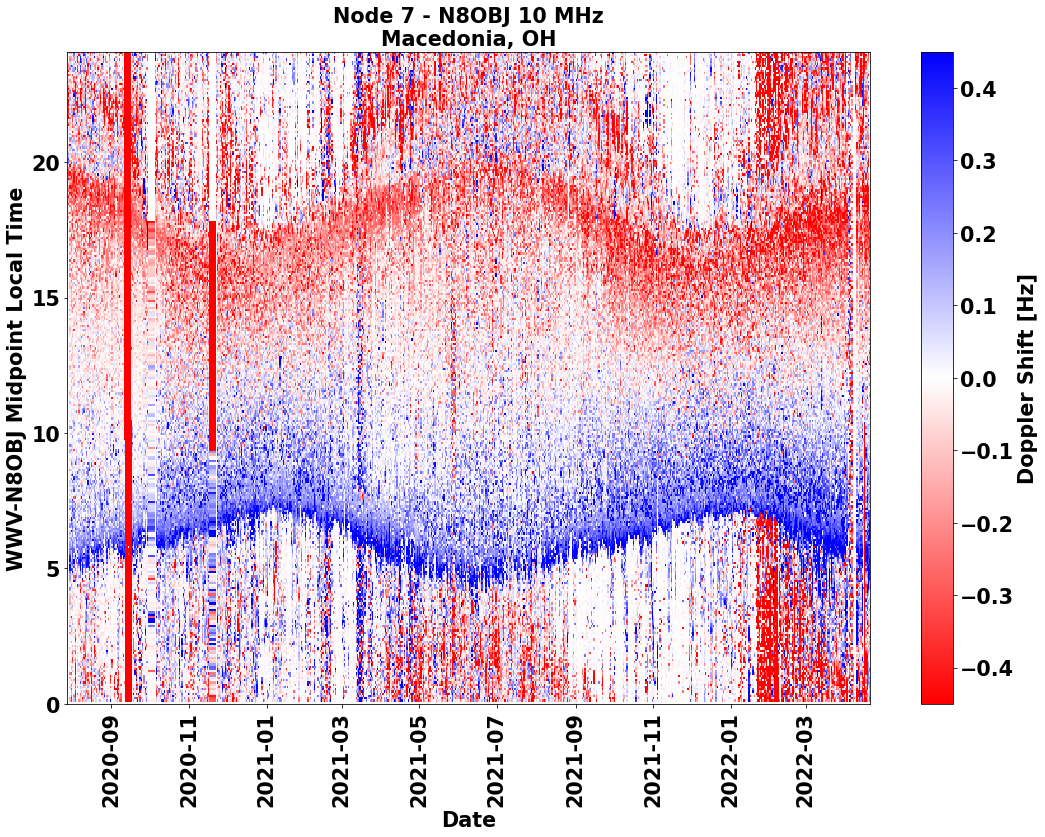

In [13]:
fig = plt.figure(figsize=(18,12))
ax  = fig.add_subplot(111)

xx = np.append(slt_days,slt_days[-1]+(slt_days[1]-slt_days[0]))
yy = np.append(slt_bins,slt_bins[-1]+(slt_bins[1]-slt_bins[0]))
cc = doppler_slt_arr.T

vmin  = -0.45
vmax  =  0.45

pcoll = ax.pcolormesh(xx,yy,cc,vmin=vmin,vmax=vmax,cmap='bwr_r')
cbar  = plt.colorbar(pcoll,label='Doppler Shift [Hz]')

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=90, horizontalalignment='center')

title = []
title.append('Node 7 - N8OBJ 10 MHz')
title.append('Macedonia, OH')
ax.set_title('\n'.join(title))

ax.set_xlabel('Date')
ax.set_ylabel('WWV-N8OBJ Midpoint Local Time')

plt.show()